4105056028 資工三 賈慶郁<br>
說明：改動了部分程式碼；註解寫於程式碼後以及段落間的 markdown cell 內

# Topic : Deep Learning 手寫辨認

## Step 0: Set the environment
前置作業，安裝 python 套件: tensorflow, keras, matplotlib, pandas

In [1]:
!pip install tensorflow
!pip install keras
!pip install matplotlib
!pip install pandas

## Step 1: Loading data and  tensorflow and keras 

### Step 1-1: Data Loading
載入套件，跳出的紅色訊息說明 Keras 背後是使用 Tensorflow (或是Theano) 當做底層運算架構

In [2]:
import tensorflow as tf
import keras

print("tensorflow version == ",tf.__version__)
print("keras version == ",keras.__version__)

tensorflow version ==  1.15.0
keras version ==  2.2.5


Using TensorFlow backend.


### Step 1-2 : Loading dataset
載入 keras 常用 datasets：mnist 手寫字符數據集。<br>
- 訓練集：
    - Xtrain
        - 包含60,000張28x28像素灰階圖像
        - 圖片由numpy陣列構成
        - 圖片的像素範圍是[0,255]，所以datatype默認為uint8
    - Ytrain
        - 數字標籤所構成的陣列(datatype=uint8)，數字標籤為[0-9]共10類
- 測試集：
    - Xtest
        - 包含10,000張28x28像素灰階圖像
        - 圖片由numpy陣列構成
        - 圖片的像素範圍是[0,255]，所以datatype默認為uint8
    - Ytest
        - 數字標籤所構成的陣列(datatype=uint8)，數字標籤為[0-9]共10類

In [3]:
# 引入 Mnist 手寫字符數據集
from keras.datasets import mnist

# 載入 Mnist 手寫辨識資料
(Xtrain,Ytrain),(Xtest,Ytest)=mnist.load_data()
print("Xtrain: type =",type(Xtrain),"\t, shape =",Xtrain.shape)
print("Ytrain: type =",Ytrain[0].dtype,"\t\t\t, lebel =",Ytrain.shape)
print("Xtest: type =",type(Xtest),"\t, shape =",Xtest.shape)
print("Ytest: type =",Ytest[0].dtype,"\t\t\t, lebel =",Ytest.shape)

XtrainO=Xtrain.copy()
YtrainO=Ytrain.copy()
XtestO=Xtest.copy()
YtestO=Ytest.copy()

Xtrain: type = <class 'numpy.ndarray'> 	, shape = (60000, 28, 28)
Ytrain: type = uint8 			, lebel = (60000,)
Xtest: type = <class 'numpy.ndarray'> 	, shape = (10000, 28, 28)
Ytest: type = uint8 			, lebel = (10000,)


import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(plt.imshow(Xtrain[0],cmap='binary'))


### Step 1-3: Exam Data : show Figures

引入 Matplotlib 進行數據資料視覺化<br>

In [0]:
import matplotlib.pyplot as plt

IPython有一組預先定義好的魔法函數（Magic Functions），可以通過命令行的語法形式來訪問它們。<br>
魔法命令都以%或者%%開頭，以%開頭的成為行命令（line magics），%%開頭的稱為單元命令（cell magics）。行命令只對命令所在的行有效，而單元命令則必須出現在單元的第一行，對整個單元的代碼進行處理。

In [0]:
# 可以內嵌繪圖，省略掉 plt.show()
%matplotlib inline

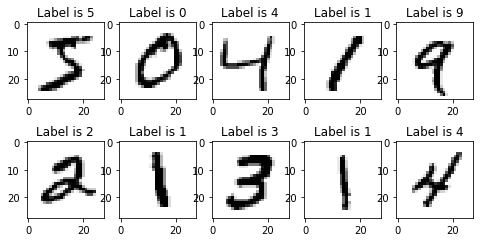

In [6]:
fig=plt.gcf()             # get current figure
fig.set_size_inches(8,4)  # 設置圖像長寬的具體尺寸(英吋)

for i in range(10):
    ax=plt.subplot(2,5,i+1) # 圖像視窗分為 2 rows 5 column，當前位置為 i+1
    ax.imshow(Xtrain[i], cmap='binary')
    ax.set_title('Label is {a}'.format(a=Ytrain[i]))

# plt.show()

# Step 2: Prepare X, Y 

資料前處理：在資料被塞進模型訓練前先進行調整，以提升 Model 預測效果

In [7]:
# 用 reshape 調整矩形的維度和形狀，這裡將二維矩陣壓縮到一維
Xtrain=Xtrain.astype('float32').reshape(60000,784)
Xtest=Xtest.astype('float32').reshape(10000,784)

# normolize the datasets
# 並將 255-pixel 的資料做正規化，使資料全部落在0到1之間
Xtrain=Xtrain/255
Xtest=Xtest/255
print('Xtrain shape=',Xtrain.shape,' type=',type(Xtrain),'dtype',Xtrain.dtype)

# Ytrain=Ytrain.reshape(60000,1)
# Ytest=Ytest.reshape(10000,1)

Xtrain shape= (60000, 784)  type= <class 'numpy.ndarray'> dtype float32


In [8]:
from keras.utils import np_utils as kerasTool
YtrainO=Ytrain.copy()

# 當特徵不是連續值，而是分類值且沒有大小順序之分
# to_categorical把類別資料做 onehot-encoding 處理，將 label 轉成向量
Ytrain=kerasTool.to_categorical(Ytrain) 
Ytest=kerasTool.to_categorical(Ytest)

#Ytrain=Ytrain.reshape(60000,10,1)1是顏色
#|Ytest=Ytest.reshape(10000,10,1)
print('Ytrain shape=',Ytrain.shape,' type=',type(Ytrain),'dtype',Ytrain.dtype)

Ytrain shape= (60000, 10)  type= <class 'numpy.ndarray'> dtype float32


# Step 3: Build Neural Network Model of Keras

### Step3-1: Model structure define
建立一個卷積圖像分類模型。<br>
這裡使用 Sequential 模型（最簡單的一種模型），其中張量將一層一層傳遞到下一層。<br>
[activation 激活函數選擇](http://mropengate.blogspot.com/2017/02/deep-learning-role-of-activation.html)

In [9]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

# 建立簡單的線性執行的模型(蛋糕夾)
model = Sequential()

# Add input layer，隱藏層(hidden layer)有256個輸出變數
# 激活函數為 relu，會使部分神經元的輸出為0，可以讓神經網路變得稀疏，緩解過度擬合的問題
#Dense每層都有連接
model.add(Dense(input_dim=784,units=256,kernel_initializer='normal',activation='relu'))

# Dropout:是暫時不訓練
# drop 掉部分神經元避免 overfit
model.add(Dropout(0.4))

# model.add(Dense(units=64,kernel_initializer='normal',activation='relu'))

# Add output layer
model.add(Dense(units=10,kernel_initializer='normal',activation='softmax'))

# 印出模型概述信息
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________
None


### Step 3-2: Define Model Training Strategy

In [10]:
# 編譯：選擇損失函數、優化方法、定義成效衡量指標 accuracy
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## Step 4: Model Fitting (need define training strategy before fitting)
https://keras-cn.readthedocs.io/en/latest/models/model/

In [11]:
# 訓練模型，並將結果存入 history
# 以compile函數進行訓練，指定訓練的樣本資料(x,y)，並撥一部分資料作驗證，還有要訓練幾個週期、訓練資料的抽樣方式
history=model.fit(x=Xtrain,y=Ytrain,validation_split=0.2,epochs=5,batch_size=200,verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 48000 samples, validate on 12000 samples
Epoch 1/5





 - 2s - loss: 0.5112 - acc: 0.8551 - val_loss: 0.2291 - val_acc: 0.9381
Epoch 2/5
 - 1s - loss: 0.2361 - acc: 0.9315 - val_loss: 0.1637 - val_acc: 0.9537
Epoch 3/5
 - 1s - loss: 0.1800 - acc: 0.9477 - val_loss: 0.1331 - val_acc: 0.9619
Epoch 4/5
 - 1s - loss: 0.1463 - acc: 0.9575 - val_loss: 0.1192 - val_acc: 0.9646
Epoch 5/5
 - 1s - loss: 0.1263 - acc: 0.9634 - val_loss: 0.1045 - val_acc: 0.9680


## Step 5: Model Evaluation

10000/10000 [==============================] - 0s 47us/step
loss= 0.09824478323608637
accuracy= 0.9715


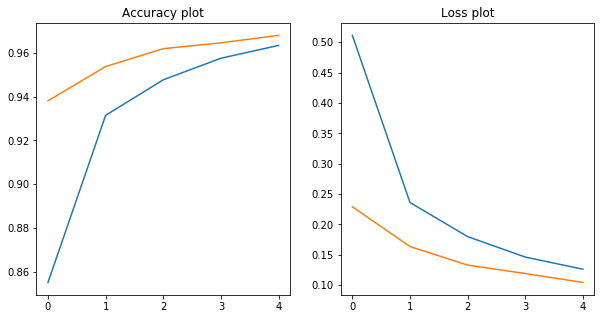

In [12]:
# 評估模型，計算成效
score=model.evaluate(Xtest,Ytest)
print('loss=',score[0])
print('accuracy=',score[1])

#================ plot figure =======================

fig=plt.gcf()
fig.set_size_inches(10,5)
                    
ax=plt.subplot(1,2,1)
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
ax.set_title('Accuracy plot')

ax=plt.subplot(1,2,2)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Loss plot')
plt.show()

## Step 6: Show Error Pictures

In [13]:
# 利用訓練好的模型進行預測
pred=list(model.predict_classes(Xtrain))
print(len(pred))
print(type(YtrainO),Ytrain.shape)
dataDict={'pred':pred, 'ans':YtrainO}
print(type(dataDict))

60000
<class 'numpy.ndarray'> (60000, 10)
<class 'dict'>


In [14]:
import pandas as pd

# 計算預測錯誤的數量
data=pd.DataFrame(dataDict)
idx=data[data.ans!=data.pred].index
idx=list(idx)
num=len(idx)
print(num)

1457


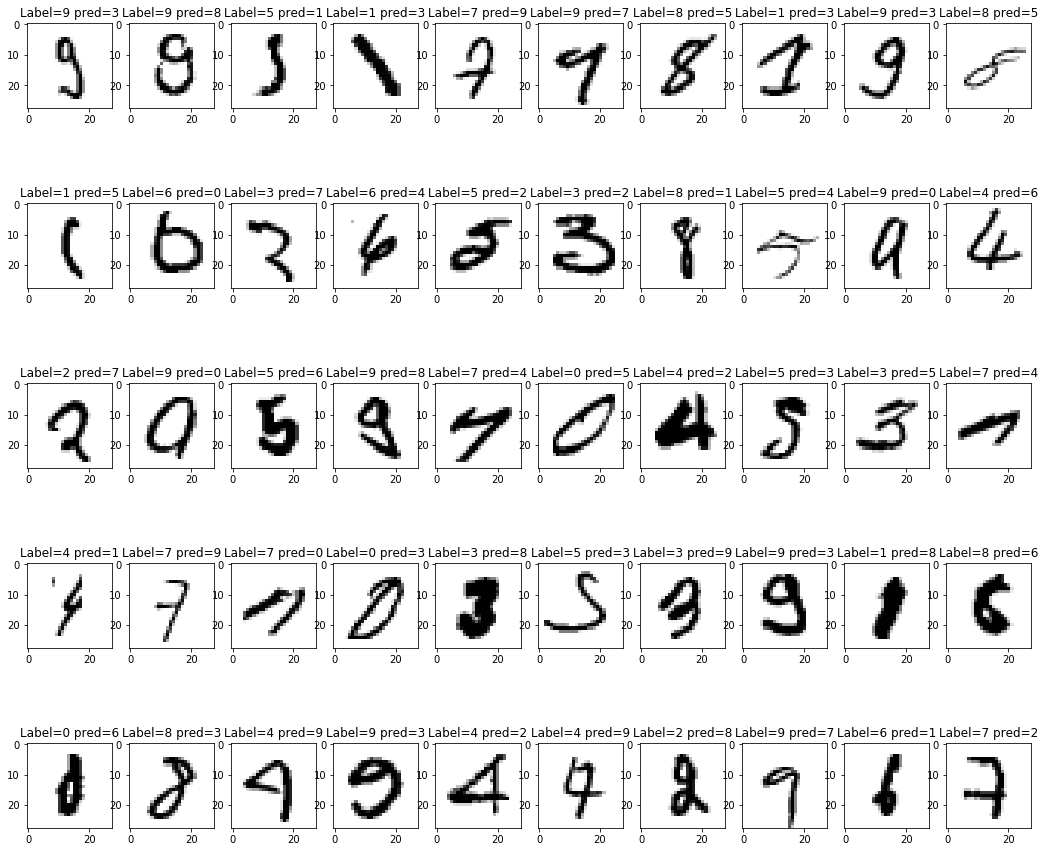

In [15]:
fig=plt.gcf()               # get current figure
fig.set_size_inches(18,16)  # 設置圖像長寬的具體尺寸(英吋)

# 印出前五十組預測錯誤的圖片
for i in range(50):
    ax=plt.subplot(5,10,i+1)
    ax.imshow(XtrainO[idx[i]], cmap='binary')    
    ax.set_title('Label={} pred={}'.format(YtrainO[idx[i]],pred[idx[i]]))

# plt.show()                